#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


## Описание задачи

Итак, задача построить модель обучения, способную предсказывать количество заказов для компании такси с целью привлечения большего количества водителей в пиковый период. Так как основная задача это предсказание количественного признака, можно сделать предварительный вывод, что следует обучать модели регрессии. Так же важным параметром задания является метрика RMSE, величина которой на тестовой выборке не должна превышать показатель 48

## Подготовка

Первым делом загрузим необходимые для работы библиотеки

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split

Теперь фаил с данными и посмотрим. Так как цель задачи связана с определением временных интервалов, сразу зададим необходимы формат для датафрейма

In [ ]:
try:
    data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Не так много данных. Посмотрим состав

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Итак, нам предоставленны данные по заказам за период с первого марта 2018 года по 31 августа 2018 года, с разбивкой по 10 минут.

Проведем ресемплирование датафрейма по часу и посмотрим

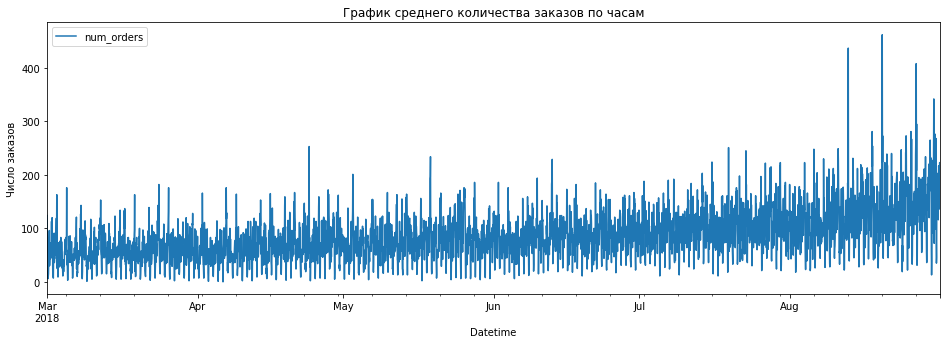

In [ ]:
data = data.resample('1H').sum()
data.plot(figsize=(16,5))
plt.title('График среднего количества заказов по часам')
plt.xlabel('Datetime')
plt.ylabel('Число заказов')
plt.show()

In [ ]:
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Данных вследствии ресемплирования стало меньше. Также по графику виден значительный рост числа заказов такси в августе.

In [ ]:
data.index.is_monotonic 

True

In [ ]:
data.index.is_unique 

True

Данные монотонны, временные индексы не повторяются.


## Анализ

Данные даны за достаточно короткий проежуток времени. Врядли в этой ситуации можно анализировать тренды или циклично повторяющиеся закономерности (сезонность). Тем не менее попробуем.

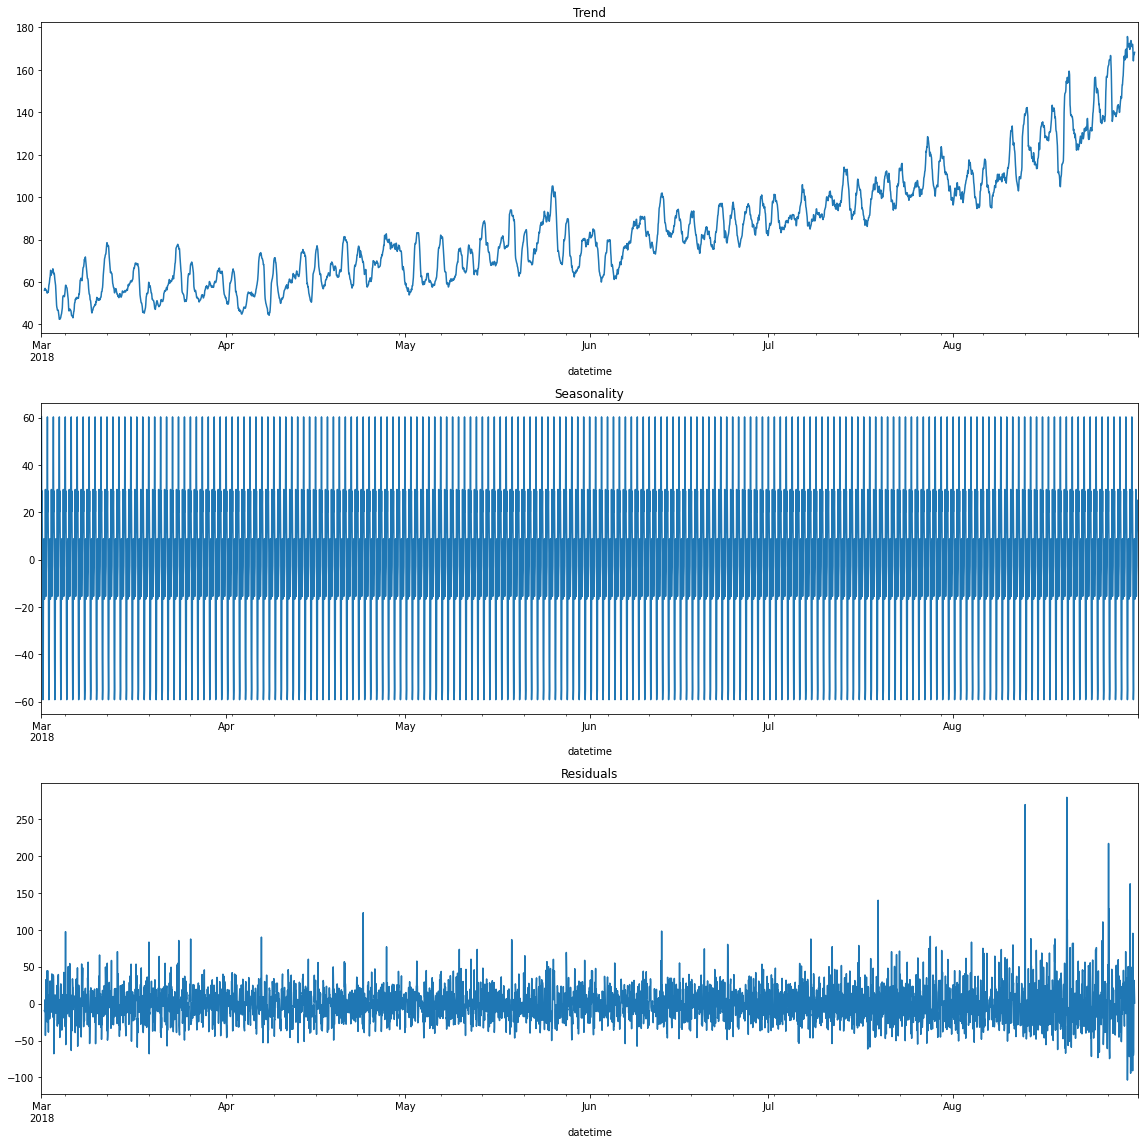

In [ ]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(16, 16))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Предположение верно. С сезонностью все плохо, что-либо понять не возможно. Зато с трендами все понятно. Виден постоянный рост с марта по август.

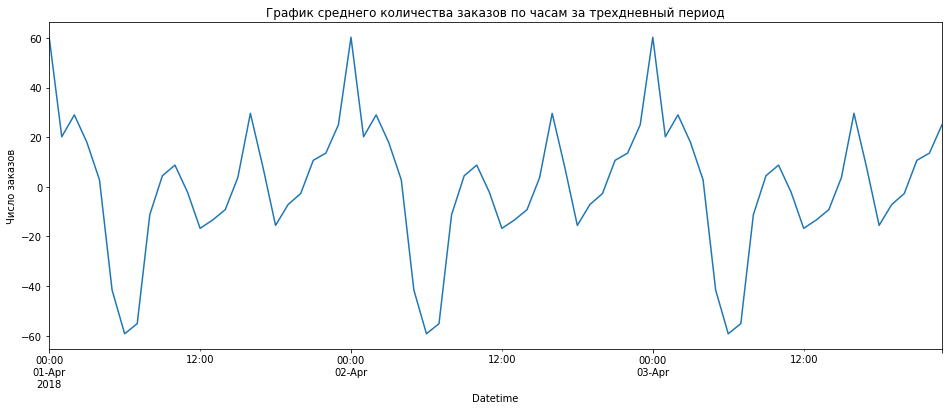

In [ ]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(16, 6))
decomposed.seasonal['2018-04-01':'2018-04-03'].plot(ax=plt.gca()) 
plt.title('График среднего количества заказов по часам за трехдневный период')
plt.xlabel('Datetime')
plt.ylabel('Число заказов')
plt.show()


Действительно, по сезонности можно сделать определенные выводы:
    1. Мы имеем дело с дневной сезонностью.
    2. Пик заказов приходится на 12 ночи кождого дня, после чего количество заказов стремительно падает до 6 утра. После 6 утра начинается рост количества заказов с незначительными флуктуациями.
    3. Падение количества заказов каждый день в 6 утра, возможно, связано с регламентым перерывом в аэропорту. В тоже время пиковые значения в ночное время, возможно, связано с режимом работы общественного транспорта и невозможностью использования альтернативных способов попасть в аэропорт

## Обучение

Прежде чем начать обучение моделей добавим календарные признаки, а так же отстающие признаки. Напишем функцию, чтобы при обучении моделей была возможность быстро менять количество значении

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    #data['year'] = data.index.year
    #data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    #data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(data, 24, 12)

Разделим датафрейм на тестовую, обучающую и валидационную выборки

In [ ]:
train_valid, test = train_test_split(data, shuffle=False, test_size=0.1)

In [ ]:
train, valid = train_test_split(train_valid, shuffle=False, test_size=0.2)
train

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-11 06:00:00,81,11,2,77.0,153.0,117.0,152.0,84.0,172.0,94.0,...,97.0,77.0,72.0,98.0,103.0,132.0,68.0,53.0,37.0,110.666667
2018-07-11 07:00:00,28,11,2,81.0,77.0,153.0,117.0,152.0,84.0,172.0,...,80.0,97.0,77.0,72.0,98.0,103.0,132.0,68.0,53.0,111.250000
2018-07-11 08:00:00,76,11,2,28.0,81.0,77.0,153.0,117.0,152.0,84.0,...,120.0,80.0,97.0,77.0,72.0,98.0,103.0,132.0,68.0,106.166667


Можно переходить к обучению

### Линейная регрессия

In [ ]:
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
 
features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']
 
model_lin_reg = LinearRegression()
 
model_lin_reg.fit(features_train, target_train)
predictions_valid = model_lin_reg.predict(features_valid)

result = mean_squared_error(target_valid, predictions_valid)**0.5 
print("RMSE наилучшей модели на валидационной выборке:", result)

RMSE наилучшей модели на валидационной выборке: 33.11196976162472


### Случайный лес

In [ ]:
best_model = None
best_result = 10000
best_est = 0
best_depth = 0
for est in range(10, 51, 10):
    for depth in range (1, 11):
        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth) 
        model.fit(features_train, target_train) 
        predictions_valid = model.predict(features_valid) 
        result = mean_squared_error(target_valid, predictions_valid)**0.5 
        if result < best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth

print("RMSE наилучшей модели на валидационной выборке:", best_result, "Количество деревьев:", best_est, "Максимальная глубина:", depth)

RMSE наилучшей модели на валидационной выборке: 34.37427970286338 Количество деревьев: 50 Максимальная глубина: 10


### Дерево решений

In [ ]:
best_model = None
best_result = 10000
best_depth = 0
for depth in range(1, 50):
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train) 
    predictions_valid = model.predict(features_valid) 
    result =  mean_squared_error(target_valid, predictions_valid)**0.5 
    if result < best_result:
        best_model = model
        best_result = result
        best_depth = depth

print("RMSE наилучшей модели на валидационной выборке:", best_result, "Глубина дерева:", best_depth)

RMSE наилучшей модели на валидационной выборке: 37.76406084768708 Глубина дерева: 8


### LGBMRegressor

In [ ]:
model_LGMB = LGBMRegressor(random_state=12345)
model_LGMB.fit(features_train, target_train)
predict_LGMB = model_LGMB.predict(features_valid)
result_LGMB = mean_squared_error(target_valid, predict_LGMB)**0.5
print("RMSE модели  на валидационной выборке:", result_LGMB)

RMSE модели  на валидационной выборке: 33.90186057928044


### CatBoostRegressor

In [ ]:
model_cat = CatBoostRegressor(n_estimators=100, silent=True)
model_cat.fit(features_train, target_train)
predictions_valid = model_cat.predict(features_valid) 

result = mean_squared_error(target_valid, predictions_valid)**0.5
print("RMSE модели на валидационной выборке:", result)

RMSE модели на валидационной выборке: 33.82305789686578


Соберем данные в таблицу, чтобы проще было анализировать результаты и сделать правильный выбор лучшей модели

In [ ]:
models = ['DecisionTreeRegressor', '38.0337'], [
    'RandomForestRegressor', '34.3073'], [
    'LinearRegression', '32.9035'], [
    'CatBoostRegressor', '33.0242'], [
    'LGBMRegressor', '33.5043']
columns = ['type', 'RMSE']
final_models = pd.DataFrame(data=models , columns=columns)
final_models

,type,RMSE
0,DecisionTreeRegressor,38.0337
1,RandomForestRegressor,34.3073
2,LinearRegression,32.9035
3,CatBoostRegressor,33.0242
4,LGBMRegressor,33.5043


Все модели показали допустимый результат. Однако лучший результат у линейной регрессий. Эту модель будем проверять на тестовой выборке

## Тестирование

In [ ]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
 
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']
 
model_lin_reg = LinearRegression()
 
model_lin_reg.fit(features_train, target_train)
predictions_valid = model_lin_reg.predict(features_test)

result = mean_squared_error(target_test, predictions_valid)**0.5 
print("RMSE наилучшей модели на тестовой выборке:", result)

RMSE наилучшей модели на тестовой выборке: 45.91900537112381


Необходимый по условию задачи результат получен. Модель работает правильно

<div class="alert alert-block alert-warning">
<b>⚠️ Совет:</b>

Рекомендую построить график с реальным и предсказанным значением тестовой выборки. Так мы сможем визуально оценить, насколько хорошо или плохо работают модели. Это один из важнейших инструментов анализа результатов моделирования временных рядов. Лучше выбрать масштаб, скажем, несколько дней, чтобы можно было увидеть и сравнить каждый час.
</div>

Построим график с реальным и предсказанным значением тестовой выборки.

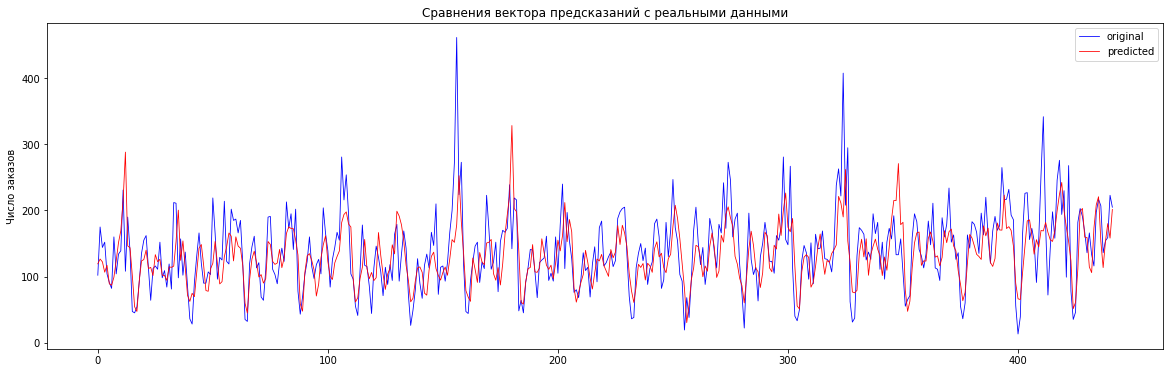

In [ ]:
x_ax = range(len(features_test))
plt.figure(figsize=(20, 6))
plt.plot(x_ax, target_test, lw=0.8, color="blue", label="original")
plt.plot(x_ax, predictions_valid, lw=0.8, color="red", label="predicted")
plt.title('Сравнения вектора предсказаний с реальными данными')
plt.ylabel('Число заказов')
plt.legend()
plt.show()

Судя по всему график предсказаний практически совпадает с реальными значениями тестовой выборки, за исключением некоторых пиковых значений, которые на графике предсказаний сглажены

## Вывод

<div class="alert alert-block alert-info">
Задачу обучения модели машинного обучения для определения пиковых периодов количества заказов такси в аэропорт для компании «Чётенькое такси» с необходимым показателем метрики RMSE выполнил. Это моделью стала Линейная регрессия. Показатель RMSE на тестовой выборке составил менее 46. 